#  Lunar Lander with Least Squares Policy Iteration (LSPI) :

Author: Nirav Lad

This notebook implements [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) as available through [Farama Foundation Gymnasium](https://gymnasium.farama.org/).  The algorithm utilized is [LSPI](https://www.jmlr.org/papers/volume4/lagoudakis03a/lagoudakis03a.pdf) with a some differences as noted (e.g. weight updates) from the paper by [Lagoudakis](https://scholar.google.com/citations?user=VqHiIg8AAAAJ) and [Parr](https://scholar.google.com/citations?user=b-GJ3QIAAAAJ).

## Import libraries

In [1]:
try:
    import google.colab
    from IPython.display import clear_output
    !apt-get install swig
    !pip install swig
    !pip install gymnasium[box2d]
    !pip install moviepy==2.2.1
    clear_output(wait=True)
except ImportError:
    pass

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import gymnasium as gym

from typing import List, Tuple, Union, Callable
from numpy.typing import NDArray
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import seaborn as sns

from gymnasium.wrappers import RecordVideo
from moviepy import VideoFileClip, TextClip, CompositeVideoClip, concatenate_videoclips
from IPython.display import Video
import os
import shutil

## Define parameters

### Enviroment variables

In [3]:
ENV_NAME = 'LunarLander-v3'

In [4]:
env = gym.make(ENV_NAME)
cardS = len( env.observation_space.low )
A = np.arange( env.action_space.n )
env.close()

num_best_policies = 10

### Hyperparameters

In [5]:
Δ = 1e-6
γ = 0.99
lr = (0.5, 0.5)

## Functions

### Helper functions

In [6]:
def calculate_mean_hw( d: Union[List[np.float32] | NDArray[np.float32]], ci:int = 0.95 ) -> Tuple[np.float32, np.float32]:
    d = np.array( d )
    n = np.size( d )
    std_error = np.std( d, ddof=1 ) / np.sqrt(n)
    t_critical = stats.t.ppf( 1 - ( 1 - ci ) / 2, n - 1 )
    mean = np.mean( d ) 
    halfwidth = t_critical * std_error
    return( mean, halfwidth )

In [7]:
def record_policy( w:NDArray[np.float32], 
                   φ:Callable[[NDArray[np.float32], int],int],
                   title:str, 
                   M:int = 10, 
                   seed:int = 1776,
                   enable_wind = False ) -> str:

    import warnings
    warnings.filterwarnings("ignore", message=".*Overwriting existing videos.*")
    os.makedirs("videos", exist_ok=True)
    env = gym.make(ENV_NAME, render_mode="rgb_array", enable_wind=enable_wind)
    env = RecordVideo(env, video_folder="videos", episode_trigger=lambda ep: True)

    G = []

    for m in np.arange(M):

        Gm = 0
        s = env.reset(seed= int( seed + m * 1e4 ) )[0]
        terminated = False
        truncated = False
        while not( terminated or truncated ):
            a = π( s, w, φ )
            sP, r, terminated, truncated, _ = env.step( a )
            s = sP
            Gm += r
        
        G.append( Gm )

    μ, δ = calculate_mean_hw( G )
    score = μ - δ

    env.close()

    video_files = sorted([f for f in os.listdir("videos") if f.endswith(".mp4")])
    annotated_clips = []
    for i, vf in enumerate(video_files):
        clip = VideoFileClip(f"videos/{vf}", )
        
        txt = TextClip( text=f"{title}\nEP {i+1:2d} Reward: {G[i]:0.1f}\nScore: {score:0.1f} ({μ:0.1f} ± {δ:0.1f})", 
                        font_size=14, 
                        color='white', 
                        method='caption',
                        vertical_align='left', horizontal_align='top',
                        size = (clip.w, 60) )
        txt = txt.with_duration(clip.duration)
        
        annotated_clip = CompositeVideoClip([clip, txt])
        annotated_clips.append(annotated_clip)

    final_clip = concatenate_videoclips(annotated_clips )

    fname = f"best_policy_({score:0.1f}).mp4"
    final_clip.write_videofile(fname)

    shutil.rmtree("videos")

    return( fname )

In [8]:
def plot_value_heatmap( w, φ, num_samples = 100, bins = 100 ):
    
    pos_x_list = []
    pos_y_list = []
    V_list_env = []
    V_list_policy = []

    env = gym.make(ENV_NAME)    
    
    for _ in range(num_samples):

        state, _ = env.reset()
        terminated = False
        truncated = False
    
        while not( terminated or truncated ):
            a = env.action_space.sample()
            sP, r, terminated, truncated, _ = env.step( a )        
            pos_x, pos_y, *_ = state
            state = sP
            V_s = np.max( [np.dot( φ( state, a ), w[a] ) for a in A ] )
            
            pos_x_list.append(pos_x)
            pos_y_list.append(pos_y)
            V_list_env.append(r)
            V_list_policy.append(V_s)

    env.close()

    cmap = LinearSegmentedColormap.from_list( 'custom_cmap', 
                                             [ (0.0, 'red'),    # Negative
                                               (0.5, 'black'),  # Zero
                                               (1.0, 'green')   # Positive
                                             ])
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    norm_env = TwoSlopeNorm(vmin=min(V_list_env), vcenter=0, vmax=max(V_list_env))
    norm_policy = TwoSlopeNorm(vmin=min(V_list_policy), vcenter=np.median(V_list_policy), vmax=max(V_list_policy))

    # First heatmap (hist2d)
    im_env = axes[0].hist2d( pos_x_list, pos_y_list, bins=bins, weights=V_list_env, cmap=cmap, norm=norm_env )
    axes[0].set_title('Environment Reward')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    plt.colorbar(im_env[3], ax=axes[0], label='R')

    # Second heatmap
    im_policy = axes[1].hist2d(  pos_x_list, pos_y_list, bins=bins, weights=V_list_policy, cmap=cmap, norm=norm_policy )
    axes[1].set_title('Expected Value')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    plt.colorbar(im_policy[3], ax=axes[1], label='$V(s)$')

    plt.tight_layout()
    plt.show()

### Basis functions

Each row of $\Phi$ contains the value of all basis functions for a certain pair $(s,a)$ and each
column of $\Phi$ contains the value of a certain basis function for all pairs $(s,a)$. Using the indicator function $I$ then we have $\Phi(s,a) = \begin{pmatrix} \phi(s,a)\times I(a=1), \cdots, \phi(s,a)\times I(a=k)\end{pmatrix}^{\intercal}$

In [9]:
def Φ( state:NDArray[np.float32], action:int, φ:Callable[[NDArray[np.float32], int], int] ) -> NDArray[np.float32]:
    return( np.hstack([ φ(state, action ) * ( a == action ) for a in A ]) )

### Poilicy function ($\pi$)

$\pi(s) =\arg \max_{a \in \mathcal{A}} \Phi(s,a)^{\intercal} w$

In [10]:
def π( state:NDArray[np.float32], w:NDArray[np.float32], φ:Callable[[NDArray[np.float32],int],int] ) -> int:
    return( np.argmax( [ np.dot( Φ( state, a, φ ), w ) for a in A ]) )

### TD Learning rate

The learning rate at episode $n$ with initial learnign rate $\alpha_a$ and learning rate decay $\alpha_b$ is defined as $\alpha_n =  a_{a}\left( \frac{1}{(1 + n)^{\alpha_{b}}} \right)$

In [11]:
def α( n:int ) -> float:
    α_init, α_decay = lr
    return( np.maximum( α_init / (n + 1)**α_decay, Δ ) )

### Generate random samples

In [12]:
def Samples( w:NDArray[np.float32], 
             φ:Callable[[NDArray[np.float32], int],int],
             num_samples:int = int(2**7), 
             max_samples:int = int(2**11), 
             seed:int = 42, 
             enable_wind:bool = False ) -> List[Tuple]:

    env = gym.make( ENV_NAME, enable_wind = enable_wind )

    np.random.seed( int( seed * 1e3 ) )

    samples = []

    while ( len(samples) <  max_samples ):

        terminated = False
        truncated = False

        s = env.reset( seed = int( seed * 1e3 ) )[0]

        while not( terminated or truncated ):
            a = π( s, w, φ )  

            sP, r, terminated, truncated, _ = env.step( a )
            samples.append( (s, a, r, sP, terminated) )
            s = sP
            if ( len(samples) == max_samples ):
                break

    env.close()

    indicies = np.random.choice( len(samples), size=num_samples, replace=False )
    random_samples = [ samples[i] for i in indicies ]

    return( random_samples )

### Evaluate policy

In [13]:
def evaluate_policy( w:NDArray[np.float32], 
                     φ:Callable[[NDArray[np.float32], int],int],
                     num_evaluations:int = 10, 
                     seed:int = 42, 
                     enable_wind:bool = False ) -> Tuple[float, float]: 

    env = gym.make( ENV_NAME, enable_wind = enable_wind )

    G = []

    for n in np.arange( num_evaluations ):
        terminated = False
        truncated = False

        Gm = 0
        s = env.reset( seed = int( seed * 1e2 + n * 3e4 ) )[0]

        while not( terminated or truncated ):
            a = π( s, w, φ )
            sP, r, terminated, truncated, _ = env.step( a )
            s = sP
            Gm += r

        G.append( Gm )

    μ, δ = calculate_mean_hw( G )

    return ( μ, δ )

### **LSTDQ**-opt

Implementation of <b>LSDQ</b>-opt that utilizes the [Sherman-Morris formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) to compute the "rank-1 update" for matrix inversion. This allows computation in $O(n^2)$ as opposed to $O(n^3)$.

<b>Inputs</b>:
- $D$: Source of samples $(s,a,r,s')$
- $k$: Number of basis functions
- $\Phi$: Basis functions
- $\gamma$: Discount factor
- $\pi$: Policy whose value function is sought

<b>algorithm</b>:<br>
1: $\mathbf{B} \gets \frac{1}{\Delta} \mathbf{I} \;\;$ is a $(k \times k)$ matrix<br>
2: $b \gets \mathbf{0} \;\;$ is a $(k \times 1)$ matrix<br>
3: <b>for each</b> $(s,a,r,s') \in D$<br>
4: &nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{B} \gets \mathbf{B} - \frac{ \mathbf{B}\Phi(s,a)\left( \Phi(s,a) - \gamma \Phi(s', \pi(s')) \right)^{\intercal} \mathbf{B} }{ 1 + \left( \Phi(s,a) - \gamma \Phi(s',\pi(s')) \right)^5: {\intercal} \mathbf{B} \Phi(s,a)}$<br>
5: &nbsp;&nbsp;&nbsp;&nbsp;$b \gets b + \Phi(s,a)r$<br>
6: $\tilde{w}^{\pi} \gets \mathbf{B}b$ results in a $(k \times 1)$ matrix<br>
7: <b>return<b> $\tilde{w}^{\pi}$

In [14]:
def LSTDQ_opt( D:List[Tuple], 
               k:int,
               w:NDArray[np.float32], 
               φ:Callable[[NDArray[np.float32], int], int], 
               n:int ) -> NDArray[np.float32]:

    B = np.eye( k ) * Δ
    b = np.zeros( k )

    i = 0
    for ( s, a, r, sP, terminated ) in D:

        Φ_sa = Φ( s, a, φ ).flatten()
        Φ_sPaP = Φ( sP, π( sP, w, φ ), φ ).flatten() * ( 1 - terminated ) 
        
        u = B @ Φ_sa
        v = ( Φ_sa - γ * Φ_sPaP ).T @ B
        
        B = B - np.outer( u, v ) / ( 1 + v @ Φ_sa )
        b = b +  r * Φ_sa
    
    wP = B @ b.T
    wP = np.asarray( wP ).ravel()

    w = ( 1 - α(n) ) * w + ( α(n) )* wP

    return( w )

### **LSPI**

The stopping criteria for this implementation is stopping after $M$ episodes. Additionally, the function returns all training policies for later evaluation rather than the superlative policy $w^*$.

<b>Inputs</b>:
- $D$: Source of samples $(s,a,r,s')$
- $k$: Number of basis functions
- $\Phi$: Basis functions
- $\gamma$: Discount factor
- $\epsilon$: Stopping criterion
- $\pi_0$: Initial policy, given as $w_0$ (default $w_0 = \mathbf{0}$)

<b>algorithm</b>:<br>
1: $\pi' \gets \pi_0$<br>
2: <b>repeat</b><br>
3: &nbsp;&nbsp;&nbsp;&nbsp;$\pi \gets \pi'$<br>
4: &nbsp;&nbsp;&nbsp;&nbsp;$\pi' \gets$ <b>LSTDQ</b> $(D,k,\Phi, \gamma, \pi)$<br>
5: <b>until</b>$(\pi \approx \pi')$ <br>
6: <b>return<b> $\pi$

In [15]:
def LSPI( w:NDArray[np.float32], 
          k:int, 
          φ:Callable[[NDArray[np.float32], int], int], 
          M:int = 500, 
          seed:int = 0, 
          enable_wind:bool=False,  
          num_samples = int(2**4), 
          max_samples=int(2**11), ) -> pd.DataFrame:

    d = []

    for m in tqdm( np.arange(M) ):

        D = Samples( w, φ, seed=( m + seed ), num_samples = num_samples, max_samples=max_samples, enable_wind=enable_wind )

        w = LSTDQ_opt( D, k, w, φ, m )
        
        μ, δ = evaluate_policy( w, φ, seed = m, enable_wind=enable_wind )

        score = μ - δ

        tqdm.write(f"Episode{m:3d}:\t{score:.2f}\t({μ:3.2f} ± {δ:3.2f})")
        d.append({'episode':m, 'score': score, 'mean': μ, 'halfwidth': δ, 'w': w.copy()})

    policies = pd.DataFrame( d )

    return( policies )

## Run **LSPI**

### Basis Function

In [16]:
def simple( state:NDArray[np.float32], action:int ) -> NDArray[np.float32]:
    return( state )

In [17]:
def interactions( state:NDArray[np.float32], action:int ) -> NDArray[np.float32]:

    px, py, vx, vy, θ, ω, lf, rf = state

    state_interactions = np.array([px*py, px*vx, px*θ, px*ω, px*lf, px*rf,
                                   py*vx, py*vy, py*θ, py*ω, py*lf, py*rf,
                                   vx*vy, vx*θ, vx*ω, vx*lf, vx*rf,
                                   vy*θ, vy*ω, vy*lf, vy*rf,
                                   θ*ω, θ*lf, θ*rf,
                                   θ*lf, θ*rf,
                                   lf*rf])
    
    return( np.hstack( ( state, state_interactions ) ) )

In [18]:
bf = simple

In [ ]:
k = len( Φ(np.zeros(cardS), A[0], bf) )
w = np.zeros( k )
policies = LSPI( w, k, bf, M=200, enable_wind=False, num_samples=2**7, max_samples=2**11 )

### Plot learning curve

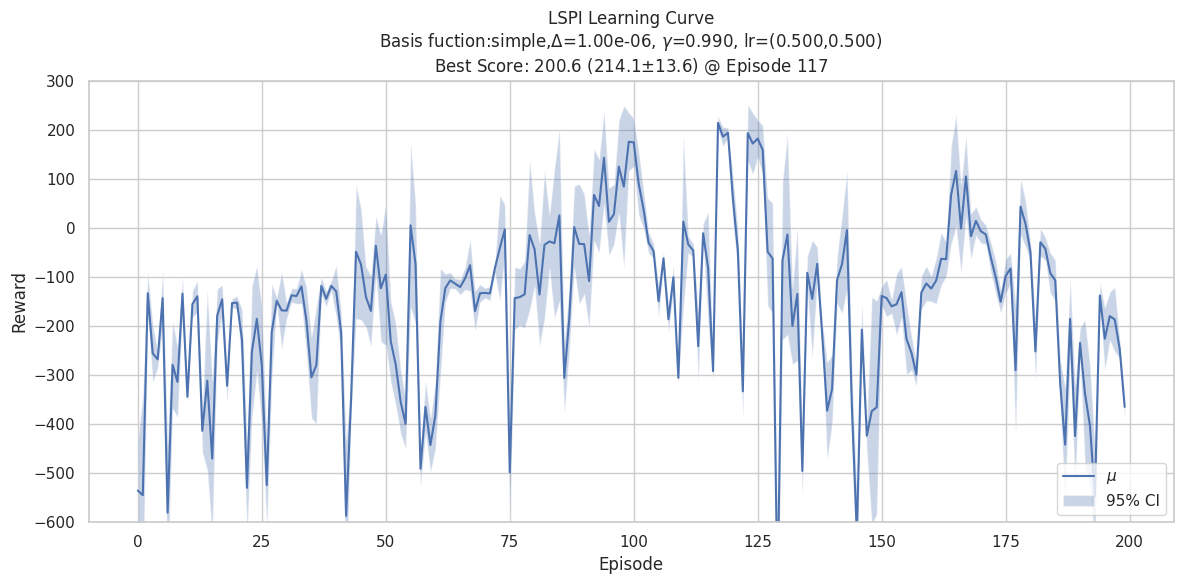

In [20]:
plt.figure(figsize=(12, 6))  
sns.set_theme(style="whitegrid") 
sns.lineplot(data=policies, x='episode', y='mean', label="$\mu$")
plt.fill_between( policies['episode'],
                  policies['mean'] - policies['halfwidth'],
                  policies['mean'] + policies['halfwidth'],
                  alpha=0.3,
                  label='95% CI')

policies.sort_values(by='score', ascending=False, inplace=True)
p = policies.iloc[0]

plt.title(f"LSPI Learning Curve\n" +\
          f"Basis fuction:{bf.__name__},$\\Delta$={Δ:.2e}, $\\gamma$={γ:0.3f}, lr=({lr[0]:0.3f},{lr[1]:0.3f})\n" + \
          f"Best Score: {p['score']:.1f} ({p['mean']:.1f}$\\pm${p['halfwidth']:.1f}) @ Episode {p['episode']}" )
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.ylim(-600, 300)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(25))
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f"learning_curve.pdf")

plt.show()

### Determine best policy ($w^*$)

In [21]:
best_score = -np.inf

print(f"EVALUATING TOP {num_best_policies} POLICES")
print("\t\tScore\t(μ ± δ)")
for i, p in policies.head(num_best_policies).iterrows():
    μ, δ = evaluate_policy(p['w'], bf, num_evaluations=30, seed=1776)
    score = μ - δ
    print(f"Episode {i:3d}\t{score:.1f}\t({μ:.1f} ± {δ:.1f})")
    if ( best_score < score ):
        best_score = score
        w_star = p['w']
        m_star = p['episode']

print(f"SUPERLATIVE POLICY:\tEPISODE {m_star}")

EVALUATING TOP 10 POLICES
		Score	(μ ± δ)
Episode 117	207.8	(217.1 ± 9.3)
Episode 119	173.0	(181.6 ± 8.6)
Episode 118	181.4	(189.1 ± 7.7)
Episode 125	172.9	(191.4 ± 18.5)
Episode 123	116.7	(168.0 ± 51.3)
Episode 100	105.4	(137.1 ± 31.7)
Episode  99	127.1	(161.2 ± 34.1)
Episode 124	163.4	(195.1 ± 31.7)
Episode 126	153.5	(172.3 ± 18.9)
Episode  94	53.0	(100.9 ± 47.9)
SUPERLATIVE POLICY:	EPISODE 117


### The superlative policy $w^*$ weights

In [22]:
np.set_printoptions(precision=2)
print(f"w*:")
print( w_star.reshape(-1,4) )

w*:
[[-1.22e-06 -1.11e-05  2.86e-07  1.54e-05]
 [ 3.74e-06  1.04e-06 -1.62e-06 -1.54e-06]
 [ 1.80e-06 -7.05e-06  2.74e-06  1.33e-05]
 [-5.52e-07  1.04e-06 -2.84e-06 -3.34e-06]
 [ 3.21e-06 -1.96e-05  5.65e-06 -1.27e-05]
 [-1.36e-06 -2.05e-07 -2.55e-06 -2.09e-06]
 [-1.57e-06 -8.75e-06 -4.12e-06  1.29e-05]
 [ 1.11e-05  1.21e-05 -3.77e-06 -3.18e-06]]


### View video recording of the best policy

In [ ]:
title = f"LSPI DELTA={Δ:.2e}, GAMMA={γ:0.3f}, lr=({lr[0]:0.3f},{lr[1]:0.3f})"
video_filename = record_policy( w_star, bf, title, enable_wind=False )
print(f"Done! Video saved to {video_filename}")

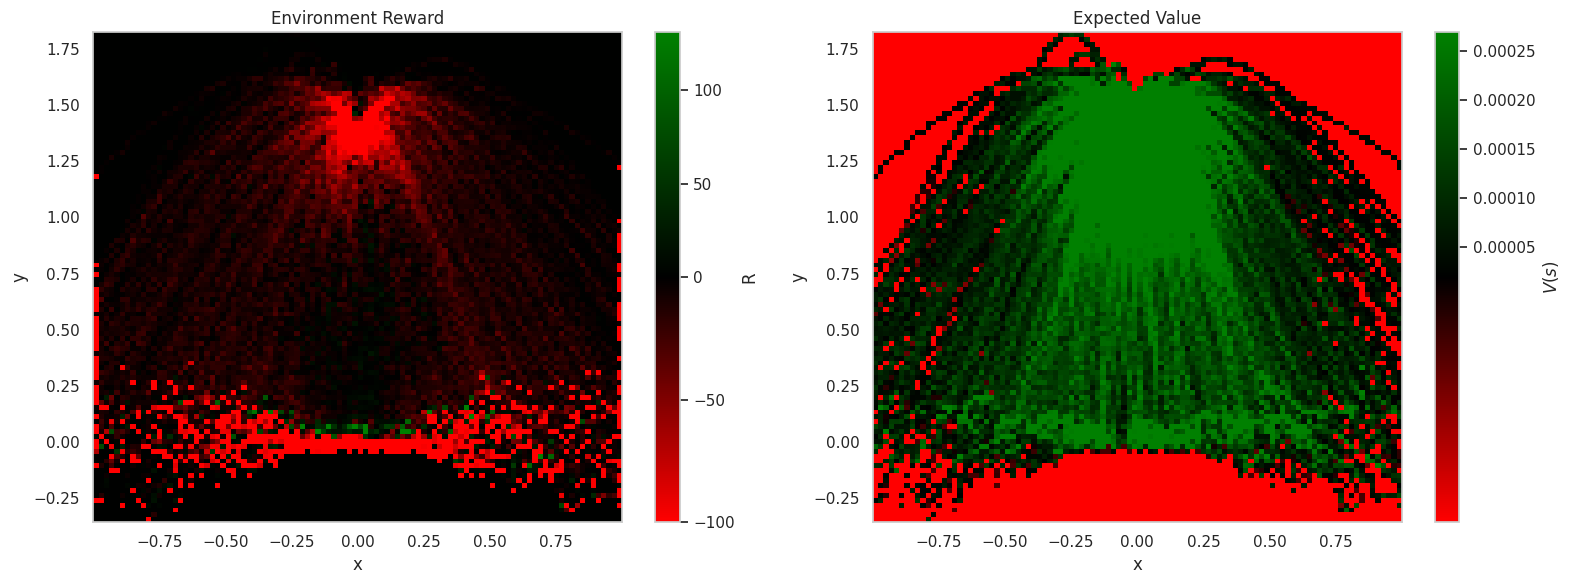

In [24]:
plot_value_heatmap( w_star, interactions, int(1000) )
Video(video_filename, embed=True)